<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_CNN_CodeChallenge_FC_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# summary info on models
from torchsummary import summary

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Create Gaussian blurs with different widths

In [3]:
nPerClass = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# the two widths (a.u.)
widths = [1.8, 2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2 * nPerClass):

    # create the gaussian with random centers
    ro = 2*np.random.randn(2) # ro = random offset
    G = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

    # and add noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i] = i % 2

labels = labels[:, None]

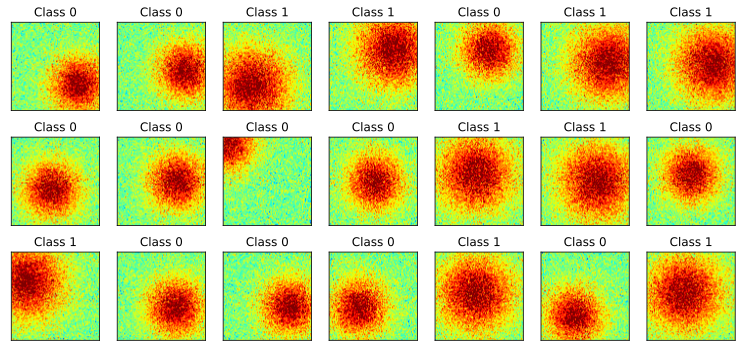

In [4]:
# visualize some images

fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create train/test groups using DataLoader

In [5]:
# step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [6]:
# check size (should be images X channels X width X height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


## Create the DL model

In [21]:
 # create a class for the model
def makeTheNet(nunit):

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            # all layers in one go using nn.Sequential

            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1),     # output size = (91 + 2 *1 - 3)/1 + 1 = 91
                nn.ReLU(),                         # note that relu is treated like a "layer"
                nn.AvgPool2d(2, 2),                # output size: 91/2 = 45
                nn.Conv2d(6, 4, 3, padding=1),     # output size = (45 + 2*1 - 3)/1 + 1 = 45
                nn.ReLU(),                         # 
                nn.AvgPool2d(2, 2),                # output size = 45/2 = 22
                nn.Flatten(),                      # vectorize conv output
                nn.Linear(22*22*4, 2*nunit),            # output size: 50
                nn.Linear(2*nunit, nunit),
                nn.Linear(nunit, 1),                  # output size: 1
            )

        def forward(self, x):
            return self.enc(x)

    
    # create the model instance
    net = gausnet()

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimzier
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer



In [22]:
# test the model with one batch
net, lossfun, optimzier = makeTheNet(25)

X, y = iter(train_loader).next()
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

## now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

 
torch.Size([32, 1])
 
Loss: 
tensor(0.6915, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [24]:
# count the total number of parametes in the model
summary(net.to(device), (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                   [-1, 25]           1,275
           Linear-10                    [-1, 1]              26
Total params: 98,431
Trainable params: 98,431
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.38
Estimated Tot

## Create a function that trains the model

In [25]:
# a function that trains the model

def function2trainTheModel(nunit):

    # number of epochs
    numepochs = 10

    # create a new model
    net, lossfun, optimizer = makeTheNet(nunit)
    net.to(device)

    # intialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs) 
    trainAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            # send data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(((yHat>0) == y).float()).item())

        # end of batch loop

        # and get average losses across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100 * np.mean(batchAcc)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():           # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat, y)

        # compare the following really long line of code to the training accuracy lines
        testLoss[epochi] = loss.item()
        testAcc[epochi] = 100 * torch.mean(( (yHat>0) == y).float()).item() 

    # end of loop

    # function output
    return trainLoss, testLoss, trainAcc, testAcc, net

In [26]:
## Run the model and show the results!

In [29]:
nunits = np.arange(5, 500, 20)
train_losses = np.zeros(len(nunits))
test_losses = np.zeros(len(nunits))
trainAccs = np.zeros(len(nunits))
testAccs = np.zeros(len(nunits))

for i, nunit in enumerate(nunits):
    print(f'{i}th iteration running')
    trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel(nunit)
    train_losses[i] = torch.mean(trainLoss[-3:]).detach()
    test_losses[i] = torch.mean(testLoss[-3:]).detach()

    trainAccs[i] = torch.mean(trainAcc[-3:]).detach()
    testAccs[i] = torch.mean(testAcc[-3:]).detach()


0th iteration running
<class 'torch.Tensor'>
1th iteration running
<class 'torch.Tensor'>
2th iteration running
<class 'torch.Tensor'>
3th iteration running
<class 'torch.Tensor'>
4th iteration running
<class 'torch.Tensor'>
5th iteration running
<class 'torch.Tensor'>
6th iteration running
<class 'torch.Tensor'>
7th iteration running
<class 'torch.Tensor'>
8th iteration running
<class 'torch.Tensor'>
9th iteration running
<class 'torch.Tensor'>
10th iteration running
<class 'torch.Tensor'>
11th iteration running
<class 'torch.Tensor'>
12th iteration running
<class 'torch.Tensor'>
13th iteration running
<class 'torch.Tensor'>
14th iteration running
<class 'torch.Tensor'>
15th iteration running
<class 'torch.Tensor'>
16th iteration running
<class 'torch.Tensor'>
17th iteration running
<class 'torch.Tensor'>
18th iteration running
<class 'torch.Tensor'>
19th iteration running
<class 'torch.Tensor'>
20th iteration running
<class 'torch.Tensor'>
21th iteration running
<class 'torch.Tensor'

In [31]:
nunits

array([  5,  25,  45,  65,  85, 105, 125, 145, 165, 185, 205, 225, 245,
       265, 285, 305, 325, 345, 365, 385, 405, 425, 445, 465, 485])

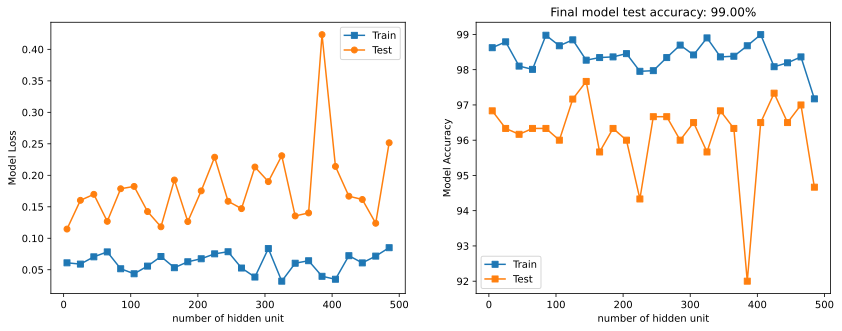

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot( nunits, train_losses, 's-', label='Train')
ax[0].plot( nunits, test_losses, 'o-', label='Test')
ax[0].set_xlabel('number of hidden unit')
ax[0].set_ylabel('Model Loss')
ax[0].legend()

ax[1].plot(nunits, trainAccs, 's-', label='Train')
ax[1].plot(nunits, testAccs, 's-', label='Test')
ax[1].set_xlabel('number of hidden unit')
ax[1].set_ylabel('Model Accuracy')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()